In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from scipy.stats import skew,norm
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("telecom_churn_data.csv")
data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [4]:
data.shape

(99999, 226)

In [5]:
# Let's filteer the data for high value customer before going to make any data preparations

np.where(data.applymap(lambda x: x == ' '))

(array([], dtype=int64), array([], dtype=int64))

In [6]:
# checking for mising values in percentages in each column

missing_values = round(100*(data.isna().sum(axis = 0)/data.shape[0]),2)
missing_values.loc[missing_values>70]

date_of_last_rech_data_6    74.85
date_of_last_rech_data_7    74.43
date_of_last_rech_data_8    73.66
date_of_last_rech_data_9    74.08
total_rech_data_6           74.85
total_rech_data_7           74.43
total_rech_data_8           73.66
total_rech_data_9           74.08
max_rech_data_6             74.85
max_rech_data_7             74.43
max_rech_data_8             73.66
max_rech_data_9             74.08
count_rech_2g_6             74.85
count_rech_2g_7             74.43
count_rech_2g_8             73.66
count_rech_2g_9             74.08
count_rech_3g_6             74.85
count_rech_3g_7             74.43
count_rech_3g_8             73.66
count_rech_3g_9             74.08
av_rech_amt_data_6          74.85
av_rech_amt_data_7          74.43
av_rech_amt_data_8          73.66
av_rech_amt_data_9          74.08
arpu_3g_6                   74.85
arpu_3g_7                   74.43
arpu_3g_8                   73.66
arpu_3g_9                   74.08
arpu_2g_6                   74.85
arpu_2g_7     

### Data summary
- Around 100k entries and 226 columns
- Mising value present but no empty strings
- No misaligned columns
- No missing column names
- Abbreviations in column names

In [7]:
# There are several columns having missing values and it is meaningful to impute them with zero such as recharge

rech_cols = ["total_rech_data_6", "total_rech_data_7", "total_rech_data_8","total_rech_data_9", "max_rech_data_6",
           "max_rech_data_7", "max_rech_data_8", "max_rech_data_9", "av_rech_amt_data_6", "av_rech_amt_data_7", 
           "av_rech_amt_data_8", "av_rech_amt_data_9"]

data[rech_cols] = data[rech_cols].fillna(0)

### Let's convert the data types of columns properly

In [8]:
#fb_user columns are categorical. Not to lose any data let's replace 0 in NAN values

fb_cols = ["fb_user_6", "fb_user_7", "fb_user_8","fb_user_9"]
data[fb_cols] = data[fb_cols].fillna(-1)

data.fb_user_6 = pd.Categorical(data.fb_user_6)
data.fb_user_7 = pd.Categorical(data.fb_user_7)
data.fb_user_8 = pd.Categorical(data.fb_user_8)
data.fb_user_9 = pd.Categorical(data.fb_user_9)

In [9]:
# night_pck_user columns are categorical. Not to lose any data let's replace 0 in NAN values

np_cols = ["night_pck_user_6", "night_pck_user_7", "night_pck_user_8", "night_pck_user_9"]
data[np_cols] = data[np_cols].fillna(-1)

data.night_pck_user_6 = pd.Categorical(data.night_pck_user_6)
data.night_pck_user_7 = pd.Categorical(data.night_pck_user_7)
data.night_pck_user_8 = pd.Categorical(data.night_pck_user_8)
data.night_pck_user_9 = pd.Categorical(data.night_pck_user_9)

### Removing columns with Zero variance or a single value

In [10]:
## There are cols with blank and zeroes as well 

print("Cols with Zero variance : ")
zero_var_cols = []
for col in data.columns:
    if (len(data[col].unique()) <= 2 ):
        print(col)
        zero_var_cols.append(col)

Cols with Zero variance : 
circle_id
loc_og_t2o_mou
std_og_t2o_mou
loc_ic_t2o_mou
last_date_of_month_6
last_date_of_month_7
last_date_of_month_8
last_date_of_month_9
std_og_t2c_mou_6
std_og_t2c_mou_7
std_og_t2c_mou_8
std_og_t2c_mou_9
std_ic_t2o_mou_6
std_ic_t2o_mou_7
std_ic_t2o_mou_8
std_ic_t2o_mou_9


In [11]:
## Lets remove the above columns as they do not add any value to the analysis
## Also deleting the mobile_number column which doesnot make sense to analyse or use for prediction. Also that it is unique for each customer

data.drop(['mobile_number','circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 
                 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9', 'std_og_t2c_mou_6',
                 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_t2c_mou_9', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 
                 'std_ic_t2o_mou_8', 'std_ic_t2o_mou_9'], axis=1, inplace=True)

print(data.shape)

(99999, 209)


In [12]:
### Finfing the High value customers according to the business definition provided

## We will consider the recharge amount for june and july ad consider the top 70% customers as high value ones

data['AVG_amt_6_7'] = data[['total_rech_amt_6', 'total_rech_amt_7']].mean(axis = 1)
data.head()

,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,...,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,AVG_amt_6_7
0,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,...,1.0,1.0,1.0,-1.0,968,30.4,0.0,101.20,3.58,307.0
1,34.047,355.074,268.321,86.285,24.11,78.68,7.68,18.34,15.74,99.84,...,-1.0,1.0,1.0,-1.0,1006,0.0,0.0,0.00,0.00,229.0
2,167.690,189.058,210.226,290.714,11.54,55.24,37.26,74.81,143.33,220.59,...,-1.0,-1.0,-1.0,1.0,1103,0.0,0.0,4.17,0.00,241.5
3,221.338,251.102,508.054,389.500,99.91,54.39,310.98,241.71,123.31,109.01,...,-1.0,-1.0,-1.0,-1.0,2491,0.0,0.0,0.00,0.00,270.0
4,261.636,309.876,238.174,163.426,50.31,149.44,83.89,58.78,76.96,91.88,...,0.0,-1.0,-1.0,-1.0,1526,0.0,0.0,0.00,0.00,273.0


In [13]:
hv_cust = data[(data['AVG_amt_6_7'] > data['AVG_amt_6_7'].quantile(0.7))]

In [14]:
hv_cust.drop(['AVG_amt_6_7'], axis = 1, inplace = True)
print(hv_cust.shape)

(29979, 209)


In [15]:
date_cols = ['date_of_last_rech_6','date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_9',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7','date_of_last_rech_data_8','date_of_last_rech_data_9']

hv_cust[date_cols] = hv_cust[date_cols].apply(pd.to_datetime, errors = 'ignore')  

In [16]:
hv_cust[date_cols].head()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9
7,2014-06-27,2014-07-25,2014-08-26,2014-09-30,NaT,NaT,NaT,NaT
8,2014-06-25,2014-07-31,2014-08-30,2014-09-30,NaT,2014-07-31,2014-08-23,NaT
13,2014-06-20,2014-07-22,2014-08-30,2014-09-26,NaT,NaT,2014-08-30,NaT
16,2014-06-30,2014-07-31,2014-08-14,2014-09-10,NaT,NaT,NaT,NaT
17,2014-06-30,2014-07-30,2014-08-25,2014-09-29,NaT,NaT,NaT,NaT


In [17]:
hv_cust[date_cols].isna().sum(axis =0 )

date_of_last_rech_6            62
date_of_last_rech_7           114
date_of_last_rech_8           594
date_of_last_rech_9           866
date_of_last_rech_data_6    18592
date_of_last_rech_data_7    18327
date_of_last_rech_data_8    18238
date_of_last_rech_data_9    18532
dtype: int64

In [18]:
# Removing the columns with more than 50% of missing values

hv_cust.drop(['date_of_last_rech_data_6', 'date_of_last_rech_data_7','date_of_last_rech_data_8','date_of_last_rech_data_9'], axis = 1, inplace = True)
date_cols = ['date_of_last_rech_6','date_of_last_rech_7',
 'date_of_last_rech_8', 'date_of_last_rech_9']

hv_cust[date_cols].head()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9
7,2014-06-27,2014-07-25,2014-08-26,2014-09-30
8,2014-06-25,2014-07-31,2014-08-30,2014-09-30
13,2014-06-20,2014-07-22,2014-08-30,2014-09-26
16,2014-06-30,2014-07-31,2014-08-14,2014-09-10
17,2014-06-30,2014-07-30,2014-08-25,2014-09-29


In [19]:
hv_cust.drop(date_cols, axis = 1, inplace = True)

In [20]:
hv_cust.shape

(29979, 201)

### Defining churn and tagging them in data frame
#### Attributes used to tag churners are 
- total_ic_mou_9
- total_og_mou_9
- vol_2g_mb_9
- vol_3g_mb_9

In [21]:
# Churn condition

churn_cond = ((hv_cust['total_ic_mou_9'] == 0) | (hv_cust['total_og_mou_9'] == 0))   \
         & ((hv_cust['vol_2g_mb_9'] == 0) | (hv_cust['vol_3g_mb_9'] == 0))

# creating churn variable.    1 implies churn and 0 as no churn
hv_cust['churn'] = np.where(churn_cond,1,0)

In [22]:
hv_cust['churn'] = hv_cust['churn'].astype('object')

In [23]:
print("Churn Ratio : ")
print(hv_cust.churn.value_counts()*100/hv_cust.shape[0])

Churn Ratio : 
0    89.849561
1    10.150439
Name: churn, dtype: float64


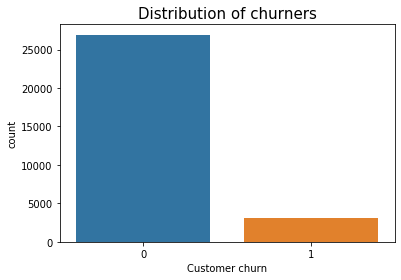

In [24]:
sns.countplot(x = hv_cust.churn)
plt.xlabel("Customer churn", fontsize = 10)
plt.ylabel('count', fontsize = 10)
plt.title("Distribution of churners", fontsize = 15)
plt.show() 

In [25]:
## Dropping all columns of churn phase

hv_cust.drop(columns = [col for col in hv_cust.columns if '_9' in col], axis = 1, inplace = True)

print("DataFrame shape : " , hv_cust.shape)

DataFrame shape :  (29979, 153)


In [26]:
churn_data = hv_cust.copy()
churn_data.reset_index(inplace = True)
churn_data.drop(['index'], axis = 1, inplace = True)
churn_data.shape

(29979, 153)

### Missing Values
#### We are left with numerical features

In [27]:
missing_num = round(100*churn_data.isnull().sum(axis = 0)/churn_data.shape[0],2)

missing_num[missing_num > 5]

count_rech_2g_6    62.02
count_rech_2g_7    61.13
count_rech_2g_8    60.84
count_rech_3g_6    62.02
count_rech_3g_7    61.13
count_rech_3g_8    60.84
arpu_3g_6          62.02
arpu_3g_7          61.13
arpu_3g_8          60.84
arpu_2g_6          62.02
arpu_2g_7          61.13
arpu_2g_8          60.84
dtype: float64

#### Almost all comlumns have missing value percentage less than 5% except for the above ones

#### The columns indicating the arpu and count_rech having missing values may most probably mean that there is no recharge or revenue from that user. 
- So it's safe to impute the mising values with 0

In [28]:
cols_to_impute = ['count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8',
'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8']

churn_data[cols_to_impute] = churn_data[cols_to_impute].fillna(0)

In [29]:
### Rechecking for mising values
churn_data.isna().sum(axis = 0)

arpu_6           0
arpu_7           0
arpu_8           0
onnet_mou_6    316
onnet_mou_7    303
              ... 
aug_vbc_3g       0
jul_vbc_3g       0
jun_vbc_3g       0
sep_vbc_3g       0
churn            0
Length: 153, dtype: int64

In [30]:
churn_data.shape

(29979, 153)

In [31]:
mv1 = round(100*(churn_data.isna().sum(axis=0)/churn_data.shape[0]), 2)
s=mv1.loc[mv1>0]
impute_cols_num = list(s.index)
print( "Length of cols having misSing values : ", len(impute_cols_num))

Length of cols having misSing values :  81


In [32]:
s

onnet_mou_6     1.05
onnet_mou_7     1.01
onnet_mou_8     3.13
offnet_mou_6    1.05
offnet_mou_7    1.01
                ... 
isd_ic_mou_7    1.01
isd_ic_mou_8    3.13
ic_others_6     1.05
ic_others_7     1.01
ic_others_8     3.13
Length: 81, dtype: float64

In [33]:
temp = churn_data.dropna()
print(churn_data.shape[0]-temp.shape[0])

1150


#### Although the number of rows being deleted if missing columns dropped are around 1.1k, it could be a loss of valuable info. So let's use KNN imputer to impute these missng values

In [34]:
from sklearn.impute import KNNImputer

impute = KNNImputer(n_neighbors=5)

In [35]:
churn_data_num = churn_data[impute_cols_num]
churn_df = churn_data.drop(impute_cols_num, axis = 1)

In [36]:
import time
# To impute the missing values using KNNImpute
start = time.time()
churn_data_impute = impute.fit_transform(churn_data_num)
end = time.time()
print("Time taken to impute missing values in seconds :",end-start)

Time taken to impute missing values in seconds : 36.8354709148407


In [37]:
churn_data_impute = pd.DataFrame(churn_data_impute, columns= impute_cols_num)
churn_data_impute.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,...,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8
0,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,...,193.94,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14
1,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,...,0.75,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00
2,501.76,108.39,534.24,413.31,119.28,482.46,23.53,144.24,72.11,7.98,...,474.41,0.45,0.0,0.0,245.28,62.11,393.39,83.48,16.24,21.44
3,50.51,74.01,70.61,296.29,229.74,162.76,0.00,2.83,0.00,0.00,...,82.44,0.00,0.0,0.0,0.00,0.00,0.23,0.00,0.00,0.00
4,1185.91,9.28,7.79,61.64,0.00,5.54,0.00,4.76,4.81,0.00,...,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00


In [38]:
churn_master = pd.concat([churn_data_impute, churn_df], axis = 1, join = 'inner')
print(churn_master.shape)
churn_master.head()

(29979, 153)


,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,...,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,churn
0,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,...,0,-1.0,-1.0,-1.0,802,57.74,19.38,18.74,0.0,1
1,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,...,0,-1.0,1.0,1.0,315,21.03,910.65,122.16,0.0,0
2,501.76,108.39,534.24,413.31,119.28,482.46,23.53,144.24,72.11,7.98,...,0,-1.0,-1.0,1.0,2607,0.00,0.00,0.00,0.0,0
3,50.51,74.01,70.61,296.29,229.74,162.76,0.00,2.83,0.00,0.00,...,0,-1.0,-1.0,-1.0,511,0.00,2.45,21.89,0.0,0
4,1185.91,9.28,7.79,61.64,0.00,5.54,0.00,4.76,4.81,0.00,...,0,-1.0,-1.0,-1.0,667,0.00,0.00,0.00,0.0,0


In [39]:
## Rechecking missing values

mv2 = round(100*(churn_master.isnull().sum(axis=0)/churn_master.shape[0]), 2)
mv2[mv2>0]

Series([], dtype: float64)

#### No missing values detected. Now our Dataframe is clean. 
## Lets analyse the features for outlier detection and treatment

In [40]:
# Outliers removal for Numeric Col
c_num = churn_master.columns[(churn_master.dtypes=="float64")|(churn_master.dtypes=="int64")].tolist()
print(c_num)

# Outliers removal for  for Cat Variables 
c_cat = churn_master.columns[(churn_master.dtypes=="object")].tolist()
c_cat

['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7', 'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6', 'loc_ic

['churn']

In [42]:
#### Removing Outliers for all numerical variables now
for col in c_num:
    print("Records in the dataframe before Outliers Removal:",churn_master.shape)
    Q1 = churn_master[col].quantile(0.01)
    Qx = churn_master[col].quantile(0.99)
    IQR = Qx - Q1
    churn_master = churn_master[(churn_master[col] >= Q1 - 1.5*IQR) & (churn_master[col] <= Qx + 1.5*IQR)]
    print("\nRemaining records in the dataframe is now:",churn_master.shape)

Records in the dataframe before Outliers Removal: (29979, 153)

Remaining records in the dataframe is now: (29970, 153)
Records in the dataframe before Outliers Removal: (29970, 153)

Remaining records in the dataframe is now: (29960, 153)
Records in the dataframe before Outliers Removal: (29960, 153)

Remaining records in the dataframe is now: (29957, 153)
Records in the dataframe before Outliers Removal: (29957, 153)

Remaining records in the dataframe is now: (29952, 153)
Records in the dataframe before Outliers Removal: (29952, 153)

Remaining records in the dataframe is now: (29947, 153)
Records in the dataframe before Outliers Removal: (29947, 153)

Remaining records in the dataframe is now: (29939, 153)
Records in the dataframe before Outliers Removal: (29939, 153)

Remaining records in the dataframe is now: (29898, 153)
Records in the dataframe before Outliers Removal: (29898, 153)

Remaining records in the dataframe is now: (29850, 153)
Records in the dataframe before Outliers

Remaining records in the dataframe is now: (27584, 153)
Records in the dataframe before Outliers Removal: (27584, 153)

Remaining records in the dataframe is now: (27581, 153)
Records in the dataframe before Outliers Removal: (27581, 153)

Remaining records in the dataframe is now: (27577, 153)
Records in the dataframe before Outliers Removal: (27577, 153)

Remaining records in the dataframe is now: (27572, 153)
Records in the dataframe before Outliers Removal: (27572, 153)

Remaining records in the dataframe is now: (27572, 153)
Records in the dataframe before Outliers Removal: (27572, 153)

Remaining records in the dataframe is now: (27498, 153)
Records in the dataframe before Outliers Removal: (27498, 153)

Remaining records in the dataframe is now: (27443, 153)
Records in the dataframe before Outliers Removal: (27443, 153)

Remaining records in the dataframe is now: (27385, 153)
Records in the dataframe before Outliers Removal: (27385, 153)

Remaining records in the dataframe is no


Remaining records in the dataframe is now: (26647, 153)
Records in the dataframe before Outliers Removal: (26647, 153)

Remaining records in the dataframe is now: (26638, 153)
Records in the dataframe before Outliers Removal: (26638, 153)

Remaining records in the dataframe is now: (26630, 153)
Records in the dataframe before Outliers Removal: (26630, 153)

Remaining records in the dataframe is now: (26558, 153)


In [43]:
# In order to derive some features variables, we should first know how the varibales are corrleated.
cor_mat = churn_master.corr()
df_corr = cor_mat.stack().reset_index().sort_values(by = 0, ascending = False)

# Lets display only significant corrleation and not everything
df_corr = df_corr[((df_corr[0] < 1) & (df_corr[0] >= 0.6)) | ((df_corr[0] <= -0.6) & (df_corr[0] > -1))]

df_corr

,level_0,level_1,0
15684,count_rech_2g_8,sachet_2g_8,0.977995
19116,sachet_2g_8,count_rech_2g_8,0.977995
15539,count_rech_2g_7,sachet_2g_7,0.973702
18971,sachet_2g_7,count_rech_2g_7,0.973702
15394,count_rech_2g_6,sachet_2g_6,0.969889
...,...,...,...
18278,arpu_2g_8,monthly_3g_7,0.601369
14652,total_rech_data_7,count_rech_2g_8,0.601246
15653,count_rech_2g_8,total_rech_data_7,0.601246
11835,total_og_mou_6,std_og_t2t_mou_6,0.601165


We can see that there are 524 columns whoich has very high correlation. The columns with same features have very high correlation with only month differing. Ex: arpu_2g_8	and arpu_3g_8. And 	total_ic_mou_7	loc_ic_mou_7. It can be handled in follwoing ways:
 - create a mean or avg. values for the last 3 months(jun,jul,aug)
 - for the recharge column, we can create mean, max, and min. value of last three months
    
Once we have all the necessary features, there is ***no need to drop the original columns*** because we will be using PCA, so importtant features can be highlighted yusing PCA.

In [44]:
# get the mean of onnet mou in the last 3 months
cols = ['onnet_mou_6','onnet_mou_7','onnet_mou_8']
churn_master['mean_onnet_mou'] = round(churn_master[cols].mean(axis=1),2)

# get the mean of offnet mou in the last 3 months
cols = ['offnet_mou_6','offnet_mou_7','offnet_mou_8']
churn_master['mean_offnet_mou'] = round(churn_master[cols].mean(axis=1),2)

# get the mean total of both onnet and offnet mou in the last 3 months
churn_master['mean_onnet_offnet_mou'] = churn_master['mean_onnet_mou'] + churn_master['mean_offnet_mou']

In [45]:
# Roaming columns
# get the mean of roam ic mou in the last 3 months
cols = ['roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8']
churn_master['mean_roam_ic_mou'] = round(churn_master[cols].mean(axis=1),2)

# get the mean of roam og mou in the last 3 months
cols = ['roam_og_mou_6','roam_og_mou_7','roam_og_mou_8']
churn_master['mean_roam_og_mou'] = round(churn_master[cols].mean(axis=1),2)

# get the mean total of both roam ic and og mou in the last 3 months
churn_master['mean_roam_mou'] = churn_master['mean_roam_ic_mou'] + churn_master['mean_roam_og_mou']

In [46]:
# loc-t2t columns
cols = ['loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8']
churn_master['mean_loc_ic_t2t_mou'] = round(churn_master[cols].mean(axis=1),2)
cols = ['loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8']
churn_master['mean_loc_og_t2t_mou'] = round(churn_master[cols].mean(axis=1),2)

churn_master['mean_loc_t2t_mou'] = churn_master['mean_loc_ic_t2t_mou'] + churn_master['mean_loc_og_t2t_mou']

# loc-t2m columns
cols = ['loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8']
churn_master['mean_loc_ic_t2m_mou'] = round(churn_master[cols].mean(axis=1),2)
cols = ['loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8']
churn_master['mean_loc_og_t2m_mou'] = round(churn_master[cols].mean(axis=1),2)

churn_master['mean_loc_t2m_mou'] = churn_master['mean_loc_ic_t2m_mou'] + churn_master['mean_loc_og_t2m_mou']

# loc-t2f columns
cols = ['loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8']
churn_master['mean_loc_ic_t2f_mou'] = round(churn_master[cols].mean(axis=1),2)
cols = ['loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8']
churn_master['mean_loc_og_t2f_mou'] = round(churn_master[cols].mean(axis=1),2)

churn_master['mean_loc_t2f_mou'] = churn_master['mean_loc_ic_t2f_mou'] + churn_master['mean_loc_og_t2f_mou']

# std-t2t columns
cols = ['std_ic_t2t_mou_6','std_ic_t2t_mou_7','std_ic_t2t_mou_8']
churn_master['mean_std_ic_t2t_mou'] = round(churn_master[cols].mean(axis=1),2)
cols = ['std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8']
churn_master['mean_std_og_t2t_mou'] = round(churn_master[cols].mean(axis=1),2)

churn_master['mean_std_t2t_mou'] = churn_master['mean_std_ic_t2t_mou'] + churn_master['mean_std_og_t2t_mou']

# std-t2m columns
cols = ['std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8']
churn_master['mean_std_ic_t2m_mou'] = round(churn_master[cols].mean(axis=1),2)
cols = ['std_og_t2m_mou_6','std_og_t2m_mou_7','std_og_t2m_mou_8']
churn_master['mean_std_og_t2m_mou'] = round(churn_master[cols].mean(axis=1),2)

churn_master['mean_std_t2m_mou'] = churn_master['mean_std_ic_t2m_mou'] + churn_master['mean_std_og_t2m_mou']

# std-t2f columns
cols = ['std_ic_t2f_mou_6','std_ic_t2f_mou_7','std_ic_t2f_mou_8']
churn_master['mean_std_ic_t2f_mou'] = round(churn_master[cols].mean(axis=1),2)
cols = ['std_og_t2f_mou_6','std_og_t2f_mou_7','std_og_t2f_mou_8']
churn_master['mean_std_og_t2f_mou'] = round(churn_master[cols].mean(axis=1),2)

churn_master['mean_std_t2f_mou'] = churn_master['mean_std_ic_t2f_mou'] + churn_master['mean_std_og_t2f_mou']

In [47]:
cols = ['loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8']
churn_master['mean_loc_ic_mou'] = round(churn_master[cols].mean(axis=1),2)
cols = ['loc_og_mou_6','loc_og_mou_7','loc_og_mou_8']
churn_master['mean_loc_og_mou'] = round(churn_master[cols].mean(axis=1),2)

churn_master['mean_loc_mou'] = churn_master['mean_loc_ic_mou'] + churn_master['mean_loc_og_mou']

# std columns
cols = ['std_ic_mou_6','std_ic_mou_7','std_ic_mou_8']
churn_master['mean_std_ic_mou'] = round(churn_master[cols].mean(axis=1),2)
cols = ['std_og_mou_6','std_og_mou_7','std_og_mou_8']
churn_master['mean_std_og_mou'] = round(churn_master[cols].mean(axis=1),2)

churn_master['mean_std_mou'] = churn_master['mean_std_ic_mou'] + churn_master['mean_std_og_mou']

# isd columns
cols = ['isd_ic_mou_6','isd_ic_mou_7','isd_ic_mou_8']
churn_master['mean_isd_ic_mou'] = round(churn_master[cols].mean(axis=1),2)
cols = ['isd_og_mou_6','isd_og_mou_7','isd_og_mou_8']
churn_master['mean_isd_og_mou'] = round(churn_master[cols].mean(axis=1),2)

churn_master['mean_isd_mou'] = churn_master['mean_isd_ic_mou'] + churn_master['mean_isd_og_mou']

# spl columns
cols = ['spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8']
churn_master['mean_spl_ic_mou'] = round(churn_master[cols].mean(axis=1),2)
cols = ['spl_og_mou_6','spl_og_mou_7','spl_og_mou_8']
churn_master['mean_spl_og_mou'] = round(churn_master[cols].mean(axis=1),2)

churn_master['mean_spl_mou'] = churn_master['mean_spl_ic_mou'] + churn_master['mean_spl_og_mou']

# others columns
cols = ['ic_others_6','ic_others_7','ic_others_8']
churn_master['mean_ic_others_mou'] = round(churn_master[cols].mean(axis=1),2)
cols = ['og_others_6','og_others_7','og_others_8']
churn_master['mean_og_others_mou'] = round(churn_master[cols].mean(axis=1),2)

churn_master['mean_others_mou'] = churn_master['mean_ic_others_mou'] + churn_master['mean_og_others_mou']

In [48]:
### Features derivation for Reacharge columns

# total_rech_num columns
cols = ['total_rech_num_6','total_rech_num_7','total_rech_num_8']
churn_master['mean_total_rech_num'] = round(churn_master[cols].mean(axis=1),2)     # mean
churn_master['min_total_rech_num'] = churn_master[cols].min(axis=1)                # Minimum
churn_master['max_total_rech_num'] = churn_master[cols].max(axis=1)                # Maximum

# total_rech_amt columns
cols = ['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8']
churn_master['mean_total_rech_amt'] = round(churn_master[cols].mean(axis=1),2)
churn_master['min_total_rech_amt'] = churn_master[cols].min(axis=1)
churn_master['max_total_rech_amt'] = churn_master[cols].max(axis=1)

# max_rech_amt columns
cols = ['max_rech_amt_6','max_rech_amt_7','max_rech_amt_8']
churn_master['mean_max_rech_amt'] = round(churn_master[cols].mean(axis=1),2)

# last_day_rch_amt columns
cols = ['last_day_rch_amt_6','last_day_rch_amt_7','last_day_rch_amt_8']
churn_master['mean_last_day_rch_amt'] = round(churn_master[cols].mean(axis=1),2)


In [49]:
# To convert object type to numeric
churn_master['churn'] = churn_master['churn'].astype('int64')

In [50]:
# To create dummies for categorical variables
churn_master=pd.get_dummies(churn_master, drop_first=True)

In [51]:
# Lets see the final shape of the df
print("The dimension of the churn_master is now:", churn_master.shape)

The dimension of the churn_master is now: (26558, 206)


In [52]:
# Lets make copy of the clean data for further analysis
final_df = churn_master.copy()
final_df.reset_index(inplace=True)
final_df.drop(['index'], axis = 1, inplace=True)
final_df.shape

(26558, 206)

In [53]:
# Final Check on null values - percentage of missing values present in each column.
mv2 = round(100*(final_df.isnull().sum(axis=0)/final_df.shape[0]), 2)
mv2.loc[mv2 > 0]

Series([], dtype: float64)

#### Handling the imbalance in the data

- There are several ways to handle the imbalance in the data such as down-sampling the majority class or upsampling the minority class
- I chose the latter because the first one might lead to serious loss of information which inturn may effect the predictions 

In [54]:
from sklearn.utils import resample

In [58]:
final_df.churn.value_counts()

0    23952
1     2606
Name: churn, dtype: int64

In [59]:
df_majority = final_df[final_df.churn==0]
df_minority = final_df[final_df.churn==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=23952,    # to match majority class
                                 random_state=42) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.churn.value_counts()

1    23952
0    23952
Name: churn, dtype: int64

### Scaling before PCA

In [62]:
df = df_upsampled.copy()

# To get the target variable
y = df.pop("churn")
y.head()

1    0
2    0
3    0
4    0
5    0
Name: churn, dtype: int64

In [63]:
# To get the independent features
X = df.copy()
X.shape

(47904, 205)

In [64]:
# Collect numerical and cat variables 
num_col = X.columns[(X.dtypes=="float64")|(X.dtypes=="int64")].tolist()
print("No. of numerical var:",len(num_col))
cat_col = X.columns[(X.dtypes=="object")].tolist()
print("No. of Categorical var:",len(cat_col))
cat_col

No. of numerical var: 193
No. of Categorical var: 0


[]

In [66]:
# Splitting the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,test_size=0.3,random_state=40)
print("Shape of X_train is:", X_train.shape)
print("Shape of X_test is:", X_test.shape)
print("Shape of y_train is:", y_train.shape)
print("Shape of y_test is:", y_test.shape)

Shape of X_train is: (33532, 205)
Shape of X_test is: (14372, 205)
Shape of y_train is: (33532,)
Shape of y_test is: (14372,)


In [67]:
# Scaling numerical variable in this section
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Dimensionality reduction using PCA

In [68]:
from sklearn.decomposition import PCA
pca = PCA(random_state=100)
pca.fit(X_train_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=100,
    svd_solver='auto', tol=0.0, whiten=False)

In [69]:
pca.components_.round(2)

array([[-0.05, -0.05, -0.02, ...,  0.11, -0.01,  0.11],
       [ 0.09,  0.11,  0.12, ..., -0.07,  0.03, -0.05],
       [ 0.05,  0.07,  0.08, ...,  0.11,  0.01,  0.11],
       ...,
       [ 0.  , -0.  , -0.  , ..., -0.07, -0.01, -0.01],
       [-0.  , -0.  , -0.  , ..., -0.05, -0.  , -0.  ],
       [-0.  ,  0.  ,  0.  , ..., -0.02, -0.01, -0.02]])

In [70]:
pca.explained_variance_ratio_.round(2)

array([0.12, 0.09, 0.07, 0.05, 0.04, 0.04, 0.03, 0.03, 0.03, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

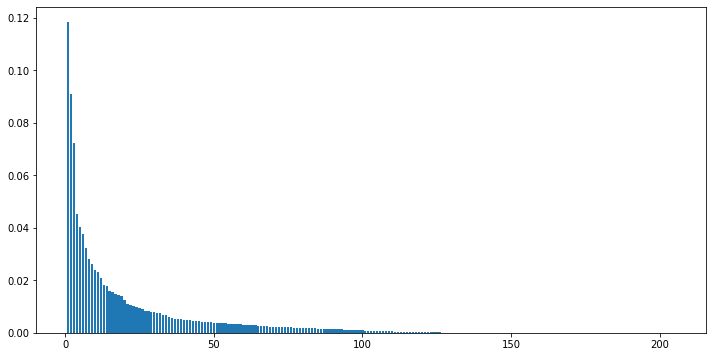

In [71]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.bar(range(1,len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_)
plt.show()

In [72]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)
var_cumu.round(2)

array([0.12, 0.21, 0.28, 0.33, 0.37, 0.4 , 0.44, 0.47, 0.49, 0.51, 0.54,
       0.56, 0.58, 0.6 , 0.61, 0.63, 0.64, 0.66, 0.67, 0.68, 0.69, 0.7 ,
       0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.78, 0.79, 0.8 ,
       0.8 , 0.81, 0.82, 0.82, 0.83, 0.83, 0.84, 0.84, 0.85, 0.85, 0.85,
       0.86, 0.86, 0.87, 0.87, 0.88, 0.88, 0.88, 0.89, 0.89, 0.89, 0.9 ,
       0.9 , 0.91, 0.91, 0.91, 0.91, 0.92, 0.92, 0.92, 0.93, 0.93, 0.93,
       0.93, 0.94, 0.94, 0.94, 0.94, 0.95, 0.95, 0.95, 0.95, 0.95, 0.96,
       0.96, 0.96, 0.96, 0.96, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97,
       0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.99, 0.99, 0.99,
       0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.

In [73]:
# Before the Scree plot, lets see the value of variance at diff. no. of PCs
for i in range(40, len(var_cumu),10):
    print("Variance explained by ",i, " no. of PCs is:", sep = " ")
    print(var_cumu[i].round(2))

Variance explained by  40  no. of PCs is:
0.84
Variance explained by  50  no. of PCs is:
0.88
Variance explained by  60  no. of PCs is:
0.92
Variance explained by  70  no. of PCs is:
0.94
Variance explained by  80  no. of PCs is:
0.96
Variance explained by  90  no. of PCs is:
0.98
Variance explained by  100  no. of PCs is:
0.99
Variance explained by  110  no. of PCs is:
1.0
Variance explained by  120  no. of PCs is:
1.0
Variance explained by  130  no. of PCs is:
1.0
Variance explained by  140  no. of PCs is:
1.0
Variance explained by  150  no. of PCs is:
1.0
Variance explained by  160  no. of PCs is:
1.0
Variance explained by  170  no. of PCs is:
1.0
Variance explained by  180  no. of PCs is:
1.0
Variance explained by  190  no. of PCs is:
1.0
Variance explained by  200  no. of PCs is:
1.0


### Scree Plot

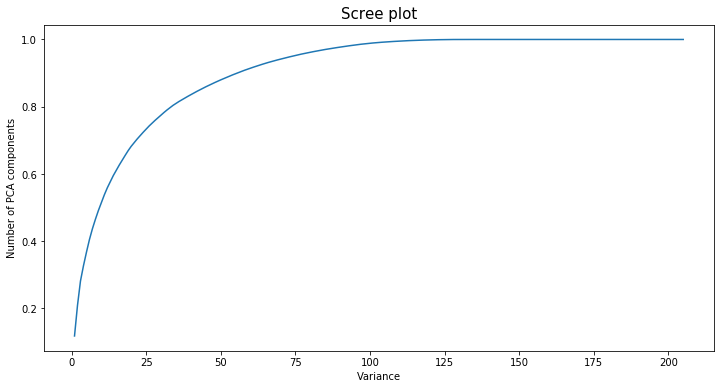

In [84]:
plt.figure(figsize=(12, 6))
plt.plot(range(1,len(var_cumu)+1), var_cumu)
plt.xlabel('Variance')
plt.ylabel('Number of PCA components')
plt.title('Scree plot', fontsize = 15)
plt.show()

#### So, we can see that with 50 Components, we can explain 88% of the variance. And with 80 PCs, we can explain 96% of the variance.

In [85]:
colnames =X.columns
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df

,PC1,PC2,Feature
0,-0.052464,0.090750,onnet_mou_6
1,-0.045798,0.111178,onnet_mou_7
2,-0.021530,0.116807,onnet_mou_8
3,-0.013511,0.112117,offnet_mou_6
4,-0.007716,0.134015,offnet_mou_7
...,...,...,...
200,0.103594,-0.077346,fb_user_6_1.0
201,-0.004231,0.019399,fb_user_7_0.0
202,0.106216,-0.074690,fb_user_7_1.0
203,-0.005591,0.028649,fb_user_8_0.0


In [88]:
# To use incremental PCA with 60 components
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=60)

In [89]:
df_train_pca = pca_final.fit_transform(X_train_scaled)
df_train_pca.shape

(33532, 60)

In [90]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(df_train_pca.transpose())

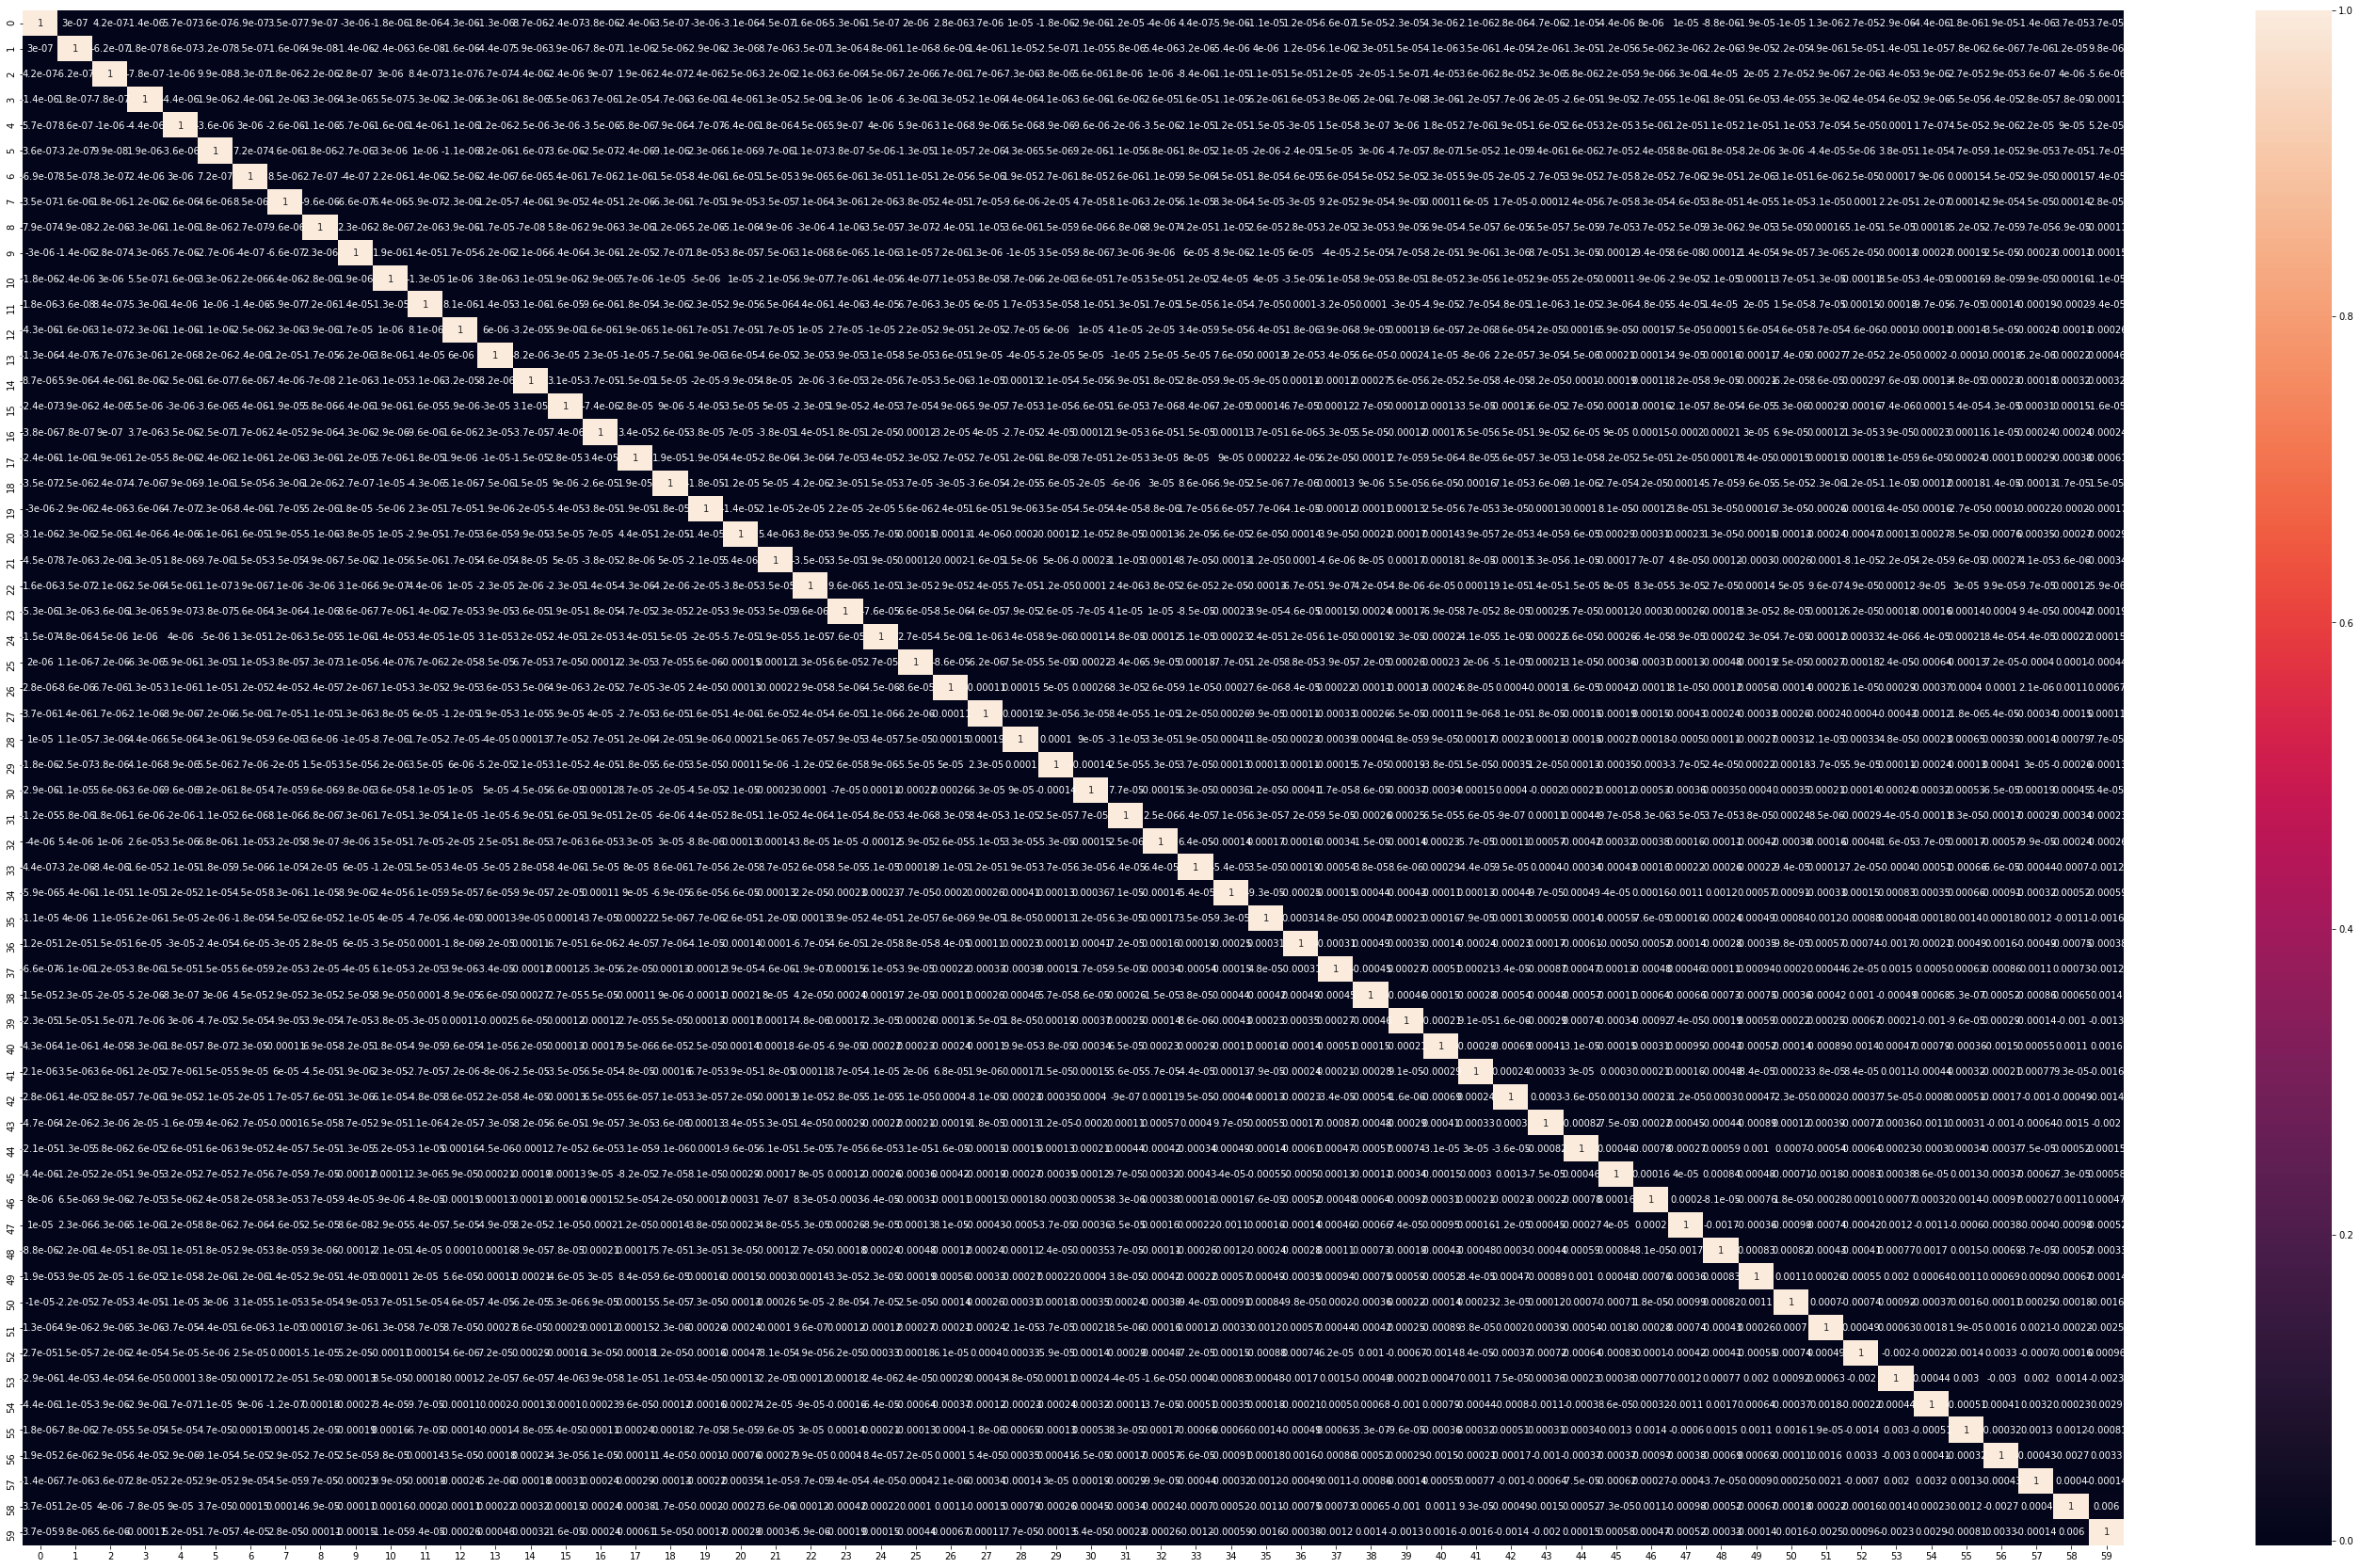

In [91]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (50,30))
sns.heatmap(corrmat,annot = True)
plt.show()

In [92]:
#Applying selected components to the test data
df_test_pca = pca_final.transform(X_test_scaled)
df_test_pca.shape

(14372, 60)

### Modelling

### Logistic Regression

In [93]:
#Training the model on the train data
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

LR_model = LogisticRegression()
LRmodel_pca = LR_model.fit(df_train_pca, y_train)


In [94]:
y_pred_LR = LRmodel_pca.predict(df_test_pca)

In [95]:
print(classification_report(y_test, y_pred_LR))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82      7169
           1       0.82      0.83      0.83      7203

    accuracy                           0.83     14372
   macro avg       0.83      0.83      0.83     14372
weighted avg       0.83      0.83      0.83     14372



In [97]:
# Evaluation on Test data
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score

y_pred = LRmodel_pca.predict(df_test_pca)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print("The Confusion Matrix for LR model is:",cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity = (True Positive)/(True Positive + False Negative): \t", round(sensitivity, 2))

The Confusion Matrix for LR model is: [[5897 1272]
 [1241 5962]]
Sensitivity = (True Positive)/(True Positive + False Negative): 	 0.83


### SVM 

In [103]:
# To import svm from sklearn and creat svm object
from sklearn import svm 
svm_linear = svm.SVC(kernel='linear')

In [105]:
# Train the svm model
st = time.time()
svm_linear_model = svm_linear.fit(df_train_pca, y_train)
et = time.time()
print("Time taken to train svm model :",et-st)

Time taken to train svm model : 555.2918469905853


In [106]:
y_pred_svm = svm_linear_model.predict(df_test_pca)

In [107]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      7169
           1       0.84      0.82      0.83      7203

    accuracy                           0.83     14372
   macro avg       0.83      0.83      0.83     14372
weighted avg       0.83      0.83      0.83     14372



In [108]:
# Evaluation on Test data

y_pred = svm_linear_model.predict(df_test_pca)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print("The Confusion Matrix for LR model is:",cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity = (True Positive)/(True Positive + False Negative): \t", round(sensitivity, 2))


The Confusion Matrix for LR model is: [[6032 1137]
 [1309 5894]]
Sensitivity = (True Positive)/(True Positive + False Negative): 	 0.82


### Random Forest

In [118]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# To create Random forest classifier with default paramters
rfc = RandomForestClassifier(oob_score = True)

In [119]:
# fit
rfc_model = rfc.fit(df_train_pca, y_train)

In [120]:
# To predict using rfc model
y_pred_rfc = rfc_model.predict(df_test_pca)

In [121]:
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      7169
           1       0.97      1.00      0.99      7203

    accuracy                           0.99     14372
   macro avg       0.99      0.99      0.99     14372
weighted avg       0.99      0.99      0.99     14372



In [122]:
# Evaluation on Test data
y_pred = rfc_model.predict(df_test_pca)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print("The Confusion Matrix for LR model is:",cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity = (True Positive)/(True Positive + False Negative): \t", round(sensitivity, 2))


The Confusion Matrix for LR model is: [[6980  189]
 [  15 7188]]
Sensitivity = (True Positive)/(True Positive + False Negative): 	 1.0


In [123]:
rfc_model.oob_score_

0.9838959799594418

# Deriving the top features now
# predictors
features = pd.DataFrame(df_train_pca).columns

# feature_importance
importance = rfc_model.feature_importances_

# create dataframe
feature_importance = pd.DataFrame({'variables': features, 'importance_percentage': (importance*100).round(2)})
feature_importance = feature_importance[['variables', 'importance_percentage']]

# sort features
feature_importance = feature_importance.sort_values('importance_percentage', ascending=False).reset_index(drop=True)
print("Sum of importance=", int(feature_importance.importance_percentage.sum()))
feature_importance